# 0.0. Imports

In [97]:
import numpy  as np
import pandas as pd
import scikitplot as skplt

import seaborn as sns
from boruta                import BorutaPy

from matplotlib import pyplot as plt

from pandas_profiling import ProfileReport

from sklearn import model_selection as ms
from sklearn import linear_model    as lm
from sklearn import preprocessing   as pp
from sklearn import ensemble        as en
from sklearn import neighbors       as nh 
from sklearn.ensemble      import RandomForestClassifier

from category_encoders import TargetEncoder

In [98]:
#!pip install scikit-plot

# 0.1. Helper Function

# 0.2. Load dataset

In [99]:
df_raw = pd.read_csv('../data/raw/train.csv')
df_raw.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


# 1.0. Data Description

In [100]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [101]:
#Lower case 
col_names = [name.lower() for name in df1.columns]

df1.columns = col_names
df1.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## 1.2. Data Dimensions

In [102]:
print('Columns: ', df1.shape[1])
print('Rows: ',df1.shape[0])

Columns:  12
Rows:  381109


## 1.3. Data Types

In [103]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.4. Check NA

In [104]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.5. Data Descriptive

In [105]:
num_attributes = df1.select_dtypes(include= ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude= ['int64', 'float64','datetime64[ns]'])


### 1.5.1. Numerical Attributes

In [106]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame(num_attributes.apply(np.mean )).T
ct2 = pd.DataFrame(num_attributes.apply(np.median )).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply( np.std)).T
d2 = pd.DataFrame(num_attributes.apply( min)).T
d3 = pd.DataFrame(num_attributes.apply( max)).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() )).T

# concat
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


### 1.5.2. Categorical Attributes

In [107]:
cat_attributes.head()

,gender,vehicle_age,vehicle_damage
0,Male,> 2 Years,Yes
1,Male,1-2 Year,No
2,Male,> 2 Years,Yes
3,Male,< 1 Year,No
4,Female,< 1 Year,No


In [108]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

gender            2
vehicle_age       3
vehicle_damage    2
dtype: int64

# 2.0. Feature Engineering

In [109]:
df2 = df1.copy()
df2.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [110]:
#vehicle_damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 0 if x == 'No' else 1)

#vehicle_age
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else 
                                              'between_1_2_year' if x == '1-2 Year' else 'below_1_year' )

df2.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,over_2_years,1,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,between_1_2_year,0,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,over_2_years,1,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,below_1_year,0,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,below_1_year,0,27496.0,152.0,39,0


# 3.0. Data Filtering

In [111]:
df3 = df2.copy()

# 4.0. Exploratoria Data Analysis

In [112]:
df4 = df3.copy()

## 4.1. Univariate Analysis



### 4.1.1. Response Variable

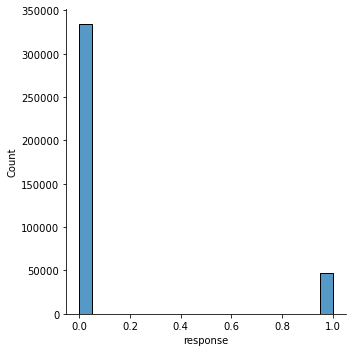

In [113]:
# analisar o label
sns.displot(df4['response'], kde=False);

In [114]:
df4.groupby(['response', 'region_code']).agg(quantity= ('id', 'count'), Age= ('age', 'median'),Premium=('annual_premium', 'mean'), Vintage=('vintage', 'mean')).sort_values('Premium').head(20)


quantity   Age       Premium     Vintage
response region_code                                          
0        1.0               899  45.0   2660.351502  154.545050
         31.0             1763  43.0   2673.854793  158.567782
         48.0             4204  49.0   2677.646289  154.920314
         20.0             1712  47.0   2747.074766  152.521028
         0.0              1847  46.0   2863.350839  155.918787
1        48.0              477  47.0   2867.400419  155.542977
         31.0              197  44.0   2872.690355  149.609137
         20.0              223  45.0   3047.044843  159.430493
         1.0               109  45.0   3131.376147  157.889908
         0.0               174  48.0   5002.798851  159.310345
         44.0               33  36.0  21089.515152  176.363636
         12.0              312  39.0  21878.336538  153.858974
         16.0              134  34.5  21915.417910  152.791045
         23.0              300  40.0  22702.416667  148.883333
0        27.0             2614  25.0  22811.244836  151.763198
         38.0             1637  44.0  23118.836286  156.795968
         16.0             1873  25.0  23143.487987  156.119060
1        3.0              1181  39.0  23189.732430  154.568163
         30.0              900  35.0  23218.614444  156.186667
         25.0              107  42.0  23259.392523  153.859813

### 4.1.2. Numerical Variable

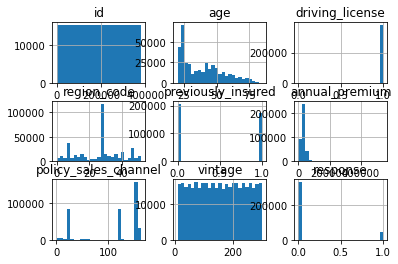

In [115]:

num_attributes.hist( bins=25 );

In [116]:
# PROFILE  

#profile = ProfileReport( df4 )
#profile.to_file( 'output_v2.html' )

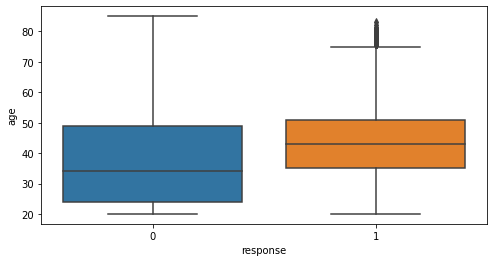

In [117]:
# Age
plt.subplots(figsize=(8, 4))
sns.boxplot( x='response', y='age', data=df4 );

<AxesSubplot:xlabel='age', ylabel='Count'>

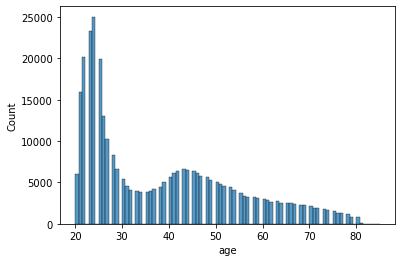

In [118]:
aux00 = df4.loc[df4['response'] == 0, 'age']
sns.histplot( aux00 )

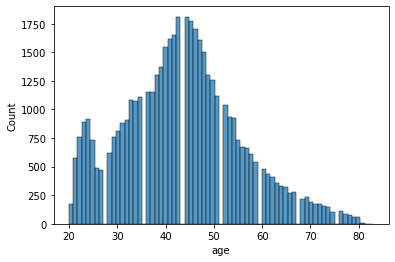

In [119]:
aux00 = df4.loc[df4['response'] == 1, 'age']
sns.histplot( aux00 );

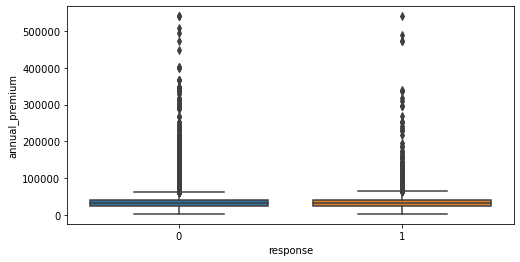

In [120]:
# Annul income
plt.subplots(figsize=(8, 4))
sns.boxplot(x='response', y='annual_premium', data=df4);

- too many outliers, try to zoon it

In [121]:
df4 = df4[(df4['annual_premium'] > 10000) &(df4['annual_premium'] < 100000)]

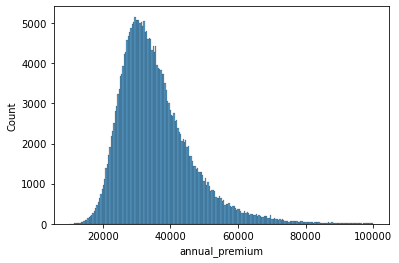

In [122]:
aux00 = df4.loc[df4['response'] == 0, 'annual_premium']
sns.histplot( aux00 );

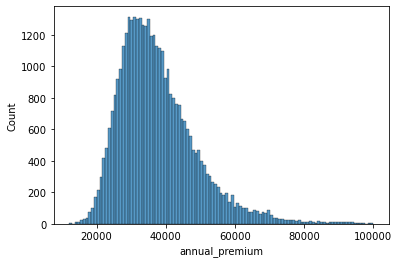

In [123]:
aux00 = df4.loc[df4['response'] == 1, 'annual_premium']
sns.histplot( aux00 );

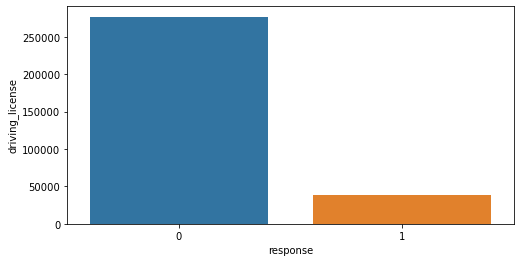

In [124]:
# driving license
plt.subplots(figsize=(8, 4))
aux = df4[['driving_license', 'response']].groupby( 'response' ).sum().reset_index()
sns.barplot( x='response', y='driving_license', data=aux );


<AxesSubplot:xlabel='region_code', ylabel='id'>

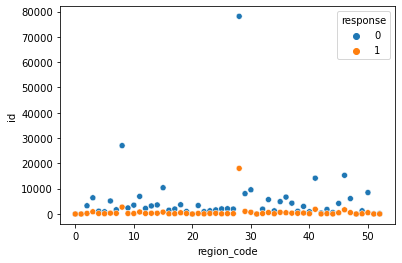

In [125]:
# region code
aux0 = df4[['id', 'region_code', 'response']].groupby( ['region_code', 'response'] ).count().reset_index()
sns.scatterplot( x='region_code', y='id', hue='response', data=aux0 )


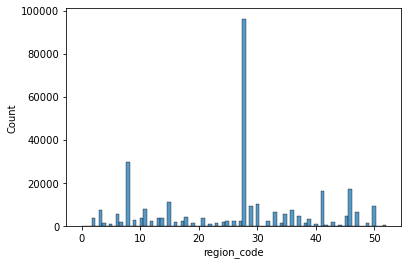

In [126]:
sns.histplot(df4['region_code']);

In [127]:
#region 28 represents 27.9% of the database
df4.loc[df4['region_code'] == 28, :].groupby([  'response']).agg(quantity= ('id', 'count'),Age= ('age', 'median'),Premium=('annual_premium', 'mean'), Vintage=('vintage', 'mean')).sort_values('Premium')


,quantity,Age,Premium,Vintage
response,,,,
0,78119,46,41685.096391,154.397368
1,18031,45,42016.139759,154.402363


In [128]:
df4.loc[df4['region_code'] == 8, :].groupby([  'response']).agg(quantity= ('id', 'count'),Age= ('age', 'median'),Premium=('annual_premium', 'mean'), Vintage=('vintage', 'mean')).sort_values('Premium')


,quantity,Age,Premium,Vintage
response,,,,
1,2724,45,40541.461821,153.109765
0,27034,30,40771.045461,154.918584


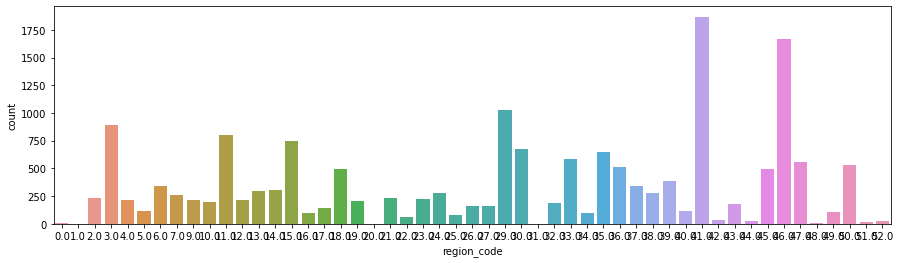

In [158]:
aux = df4[(df4['region_code'] != 28)& (df4['region_code'] != 8) & (df4['response'] == 1)]
fig = plt.subplots(figsize = (15,4))
sns.countplot(x = 'region_code', data = aux);

In [129]:
# Previous insured
pd.crosstab(df4['previously_insured'], df4['response'] ).apply( lambda x: x / x.sum(), axis=1 )

response,0,1
previously_insured,,
0,0.769438,0.230562
1,0.999191,0.000809


- 99% of one condition, may generate viés 

In [130]:
df4['vehicle_damage'].unique()

array([1, 0], dtype=int64)

<AxesSubplot:xlabel='response', ylabel='policy_sales_channel'>

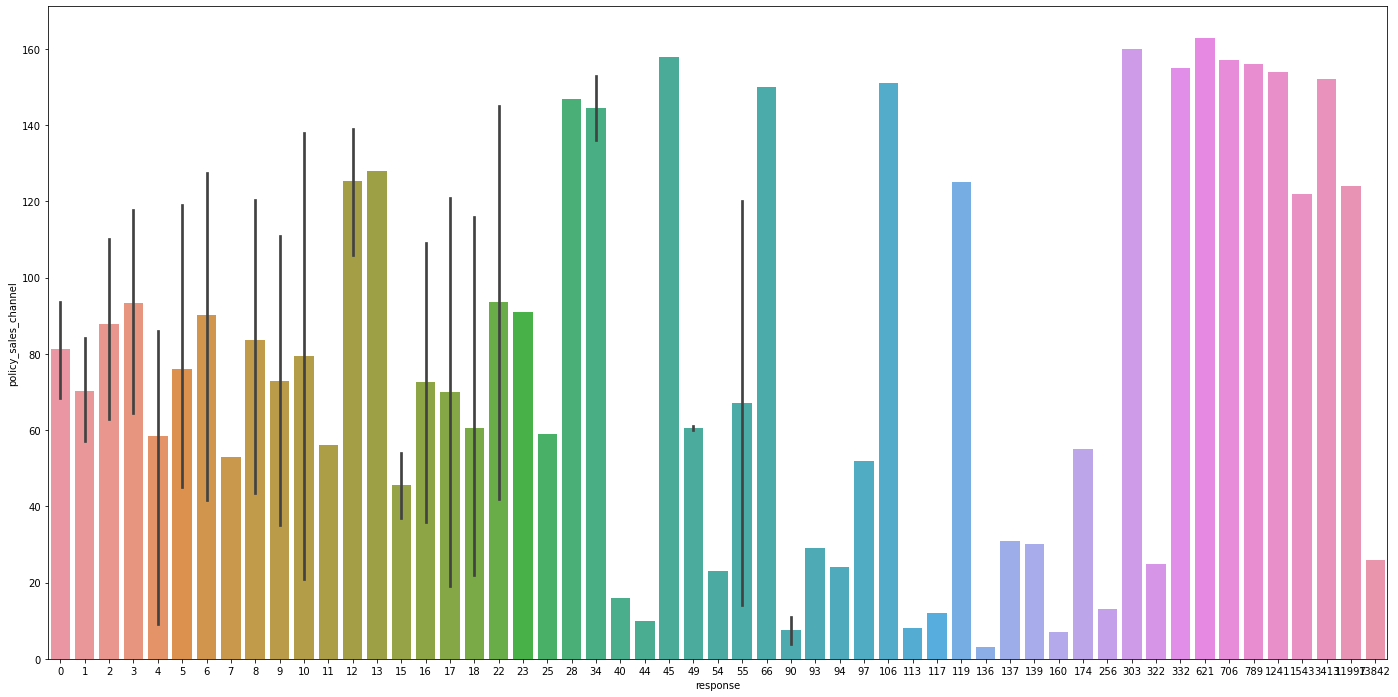

In [131]:
#'policy_sales_channel'
plt.figure( figsize=(24, 12 ))
aux = df4[['policy_sales_channel', 'response']].groupby( 'policy_sales_channel').sum().reset_index()
sns.barplot( x='response', y='policy_sales_channel', data=aux )

### 4.1.3. Categorical Variable

C:\Users\ACER\anaconda3\envs\datasciencemproducao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\ACER\anaconda3\envs\datasciencemproducao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


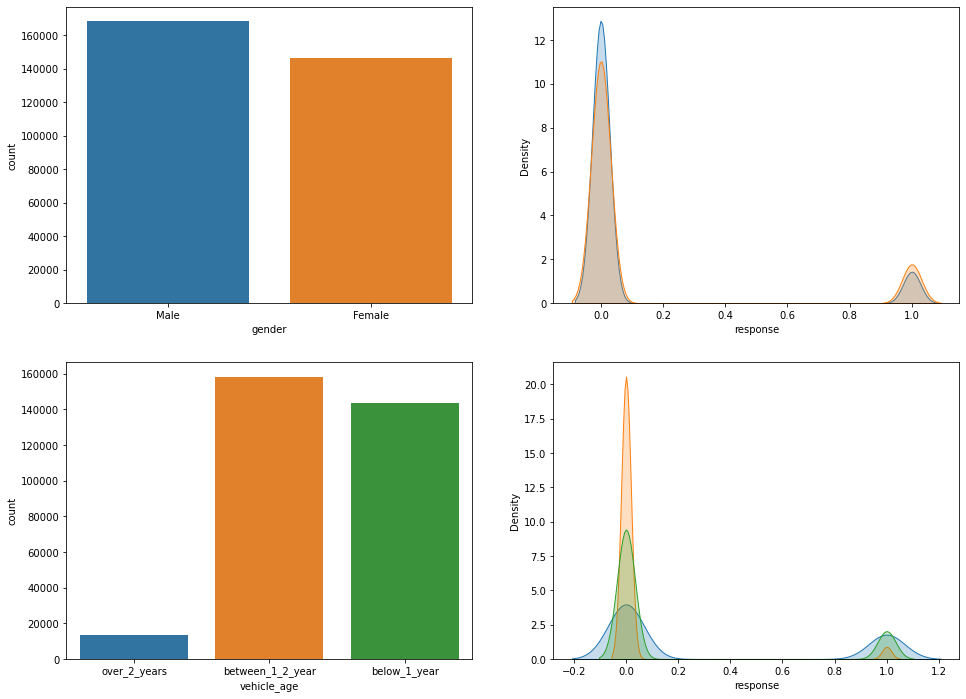

In [132]:
#gender vehicle_age vehicle_damage

plt.figure( figsize=(16, 12 ))
# Gender

plt.subplot( 2, 2, 1 )
sns.countplot( df4['gender'] );

plt.subplot( 2, 2, 2 )
sns.kdeplot( df4[df4['gender'] == 'Female']['response'], label='female', shade=True );
sns.kdeplot( df4[df4['gender'] == 'Male']['response'], label='male', shade=True );

# Vehicle_age
plt.subplot( 2, 2, 3 )
sns.countplot( df4['vehicle_age'] )

plt.subplot( 2, 2, 4 )
sns.kdeplot( data= df4[df4['vehicle_age'] == 'over_2_years']['response'], label='over_2_years', shade=True );
sns.kdeplot( data=df4[df4['vehicle_age'] == 'below_1_year']['response'], label='below_1_year', shade=True );
sns.kdeplot( data=df4[df4['vehicle_age'] == 'between_1_2_year']['response'], label='between_1_2', shade=True );



In [133]:
# vehicle_age
df4[['id','vehicle_age', 'response']].groupby( ['vehicle_age', 'response'] ).count().reset_index()

,vehicle_age,response,id
0,below_1_year,0,137861
1,below_1_year,1,5994
2,between_1_2_year,0,130381
3,between_1_2_year,1,28017
4,over_2_years,0,9126
5,over_2_years,1,4070


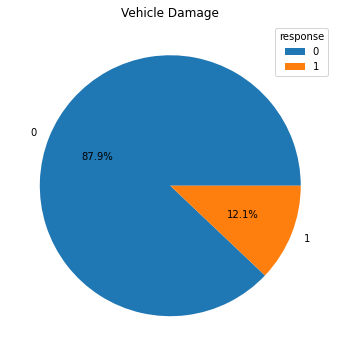

In [134]:
plt.figure( figsize=(10, 6 ))

# vehicle damage
a=df4.groupby('response').count()[['vehicle_damage']].reset_index()
plt.pie(a['vehicle_damage'], labels =a['response'], autopct="%.1f%%");
plt.legend(title = "response");
plt.title('Vehicle Damage');



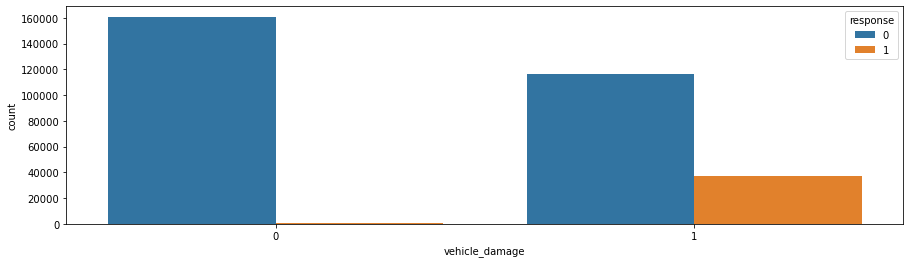

In [159]:
fig, axs = plt.subplots(figsize = (15,4))
sns.countplot(x = df4['vehicle_damage'], hue = df4['response']);

# 5.0. Data Preparation

In [136]:
df5 = df4.copy()

In [137]:
X = df4.drop( 'response', axis=1 )
y = df4['response'].copy() 

x_train, x_validation, y_train, y_validation = ms.train_test_split( X, y, test_size=0.20 )

df5 = pd.concat( [x_train, y_train], axis=1 )

## 5.1. Standardization

In [138]:
ss = pp.StandardScaler()

# annual_premium
df5['annual_premium'] = ss.fit_transform( df5[['annual_premium']].values )

## 5.2. Rescaling

In [139]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# Age
df5['age'] = mms_age.fit_transform( df5[['age']].values )

# vintage
df5['vintage'] = mms_vintage.fit_transform( df5[['vintage']].values )

### 5.3.1. Encoding

## Encoder

In [140]:
# gender - One Hot Encoding / Target Encoding

encoder_gender =TargetEncoder()
df5['gender'] = encoder_gender.fit_transform(df5['gender'], df5['response'])

# region_code - Target Encoding / Frequency Encoding
target_encode_region_code = df5.groupby( 'region_code' )['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map( target_encode_region_code )


## vehicle_age - One Hot Encoding / Frequency Encoding
df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )

## policy_sales_channel - Target Encoding / Frequency Encoding
fe_policy_sales_channel = df5.groupby( 'policy_sales_channel' ).size() / len( df5 ) 
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( fe_policy_sales_channel )

C:\Users\ACER\anaconda3\envs\datasciencemproducao\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


## 5.4. Validation Preparation

In [141]:
# gender
x_validation.loc[:, 'gender'] =  encoder_gender.transform(x_validation[['gender']], y=None )

# age
x_validation.loc[:, 'age'] = mms_age.transform( x_validation[['age']].values )

# region_code
x_validation.loc[:, 'region_code'] = x_validation.loc[:, 'region_code'].map( target_encode_region_code )

# vehicle_age
x_validation = pd.get_dummies( x_validation, prefix='vehicle_age', columns=['vehicle_age'] )

# annual_premium
x_validation.loc[:, 'annual_premium'] = ss.transform( x_validation[['annual_premium']].values )

# policy_sales_channel
x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map( fe_policy_sales_channel )

# vintage
x_validation.loc[:, 'vintage'] = mms_vintage.transform( x_validation[['vintage']].values )

# fillna
x_validation = x_validation.fillna( 0 )

C:\Users\ACER\anaconda3\envs\datasciencemproducao\lib\site-packages\pandas\core\indexing.py:1787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)
C:\Users\ACER\anaconda3\envs\datasciencemproducao\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\ACER\anaconda3\envs\datasciencemproducao\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 


In [142]:
df5.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_damage,annual_premium,policy_sales_channel,vintage,response,vehicle_age_below_1_year,vehicle_age_between_1_2_year,vehicle_age_over_2_years
157788,157789,0.138940,0.046154,1,0.188374,0,1,1.011689,0.385942,0.446367,0,1,0,0
314233,314234,0.100667,0.046154,1,0.188374,1,0,0.616001,0.385942,0.314879,0,1,0,0
7438,7439,0.138940,0.415385,1,0.188374,0,1,0.957623,0.196157,0.017301,0,0,1,0
5631,5632,0.138940,0.569231,1,0.113966,0,1,0.335008,0.196157,0.477509,0,0,1,0
302610,302611,0.100667,0.030769,1,0.092334,1,0,1.239528,0.385942,0.667820,0,1,0,0


# 6.0. Feature Selection

In [143]:
df6 = df5.copy()

## 6.1. Boruta Algorithm

In [144]:
## training and test dataset for Boruta
#x_train_b = df6.drop(['id', 'response'], axis = 1).values
#y_train_b = y_train.values.ravel()
#
#
## define RandomForestRegressor
#rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
#
## define Boruta feature selection method
#boruta_feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit( x_train_b,y_train_b )
#
## find all relevant features
#boruta_feat_selector.fit(x_train_b,y_train_b )
#
## check ranking of features
#boruta_feat_selector.ranking_

In [145]:
#cols_selected = boruta_feat_selector.support_.tolist()
#
##colunas selecionadas
#x_train_fs = df6.drop(['id', 'response'], axis = 1)
#cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()
#
##colunas não selecionadas
#cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns,cols_selected_boruta))
#
#print("BorutaSelected Column: \n",cols_selected_boruta )
#
#
#print("Boruta NOT Selected Column:", cols_not_selected_boruta )


## 6.2. Feature Importance

In [146]:
# model definition
forest = en.ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1 )

# data preparation
x_train_n = df5.drop( ['id', 'response'], axis=1 )
y_train_n = y_train.values
forest.fit( x_train_n, y_train_n )

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=-1,
                     oob_score=False, random_state=0, verbose=0,
                     warm_start=False)

feature ranking
                        feature  importance
0                annual_premium    0.272927
0                       vintage    0.247149
0                           age    0.159153
0                   region_code    0.102000
0                vehicle_damage    0.070431
0            previously_insured    0.059975
0          policy_sales_channel    0.057060
0      vehicle_age_below_1_year    0.016123
0  vehicle_age_between_1_2_year    0.006786
0                        gender    0.004679
0      vehicle_age_over_2_years    0.003215
0               driving_license    0.000500


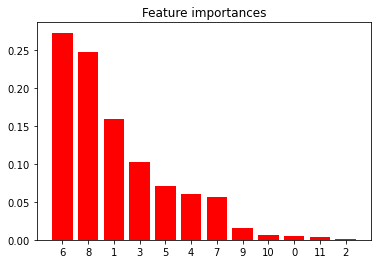

In [147]:
importances = forest.feature_importances_
indices = np.argsort( importances )[::-1]

print( 'feature ranking')
df = pd.DataFrame()

for i, j in zip( x_train_n, forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 )
    
print( df.sort_values( 'importance', ascending=False ) )

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

Selected Columns :

From EDA Analysis:
    
            'gender', age','annual_preminum', 'policy_sales_channel', 'region_code', 'vehicle_age'
         
From Boruta
       
         'gender', 'age', 'driving_license', 'region_code', 'previously_insured', 'vehicle_damage', 'annual_premium', 
         'policy_sales_channel', 'vehicle_age_below_1_year', 'vehicle_age_between_1_2_year', 'vehicle_age_over_2_years'
    

From Features Importance - untill 5% 

        'annual_premium', 'vintage', 'age', 'region_code','vehicle_damage', 'policy_sales_channel', 'previously_insured'.        
Features final list:
    

# 7.0. Machine Learning Modelling

In [148]:
df7 = df6.copy()

In [149]:
column_selected = ['annual_premium', 'vintage', 'age', 'region_code','vehicle_damage', 'policy_sales_channel']

X_train = df7[column_selected]
x_test= x_validation[column_selected]
y_test = y_validation.copy()

## 7.1. KNN Classifier

In [150]:
# model definition
knn_model = nh.KNeighborsClassifier( n_neighbors=7 )

# model training
knn_model.fit( X_train, y_train )

# model prediction - Poder de GENERALIZACAO 
yhat_knn = knn_model.predict_proba( x_test )

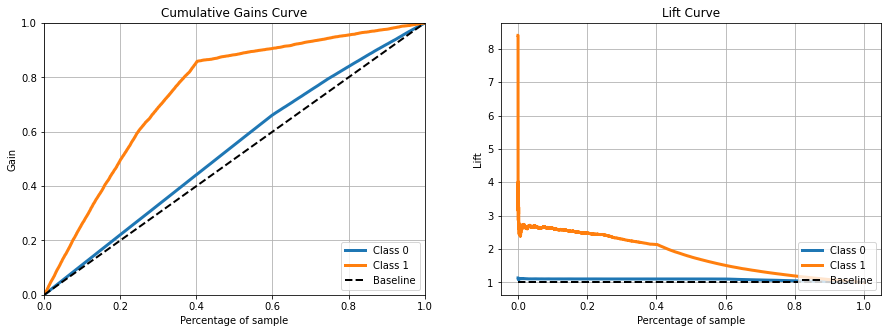

In [166]:
fig, axs = plt.subplots(ncols= 2, figsize = (15,5))
skplt.metrics.plot_cumulative_gain(y_test, yhat_knn, ax=axs[0])
skplt.metrics.plot_lift_curve(y_test, yhat_knn,ax=axs[1]);

## 7.2. Logistic Regression

In [151]:
# model definition
lr_model = lm.LogisticRegression( random_state=42 ) 

# model training
lr_model.fit( X_train, y_train )

# model prediction
yhat_lr = lr_model.predict_proba( x_test )

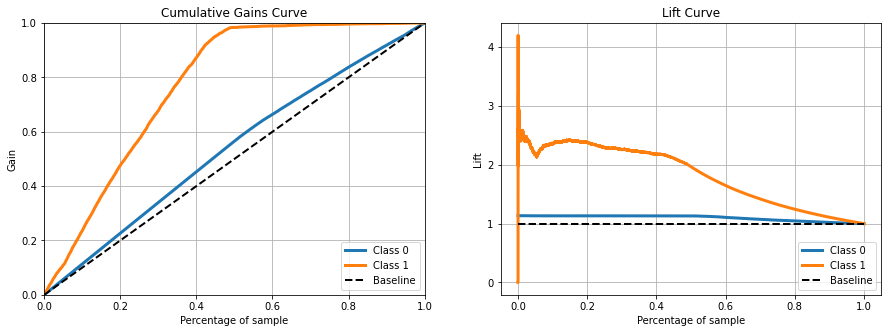

In [165]:
fig, axs = plt.subplots(ncols= 2, figsize = (15,5))
skplt.metrics.plot_cumulative_gain(y_test, yhat_lr, ax=axs[0])
skplt.metrics.plot_lift_curve(y_test, yhat_lr,ax=axs[1]);

## 7.3. RandomForest Classifies

In [160]:
# model definition
rfc_model = RandomForestClassifier(n_estimators = 300, random_state = 42)

# model fit
rfc_model.fit( X_train, y_train )

# model predict
yhat_rfc = rfc_model.predict_proba( x_test )



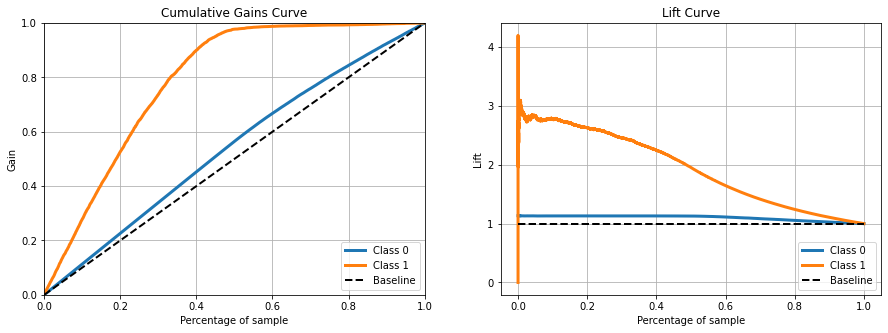

In [161]:
fig, axs = plt.subplots(ncols= 2, figsize = (15,5))
skplt.metrics.plot_cumulative_gain(y_test, yhat_rfc, ax=axs[0])
skplt.metrics.plot_lift_curve(y_test, yhat_rfc,ax=axs[1]);

- **Ordering Metrics**

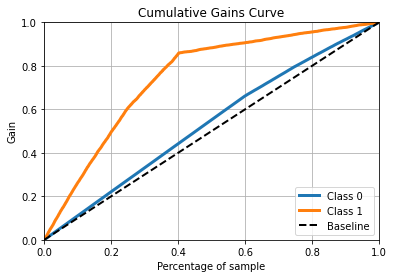

In [162]:
#Accumulative Gain KNN
skplt.metrics.plot_cumulative_gain( y_test, yhat_knn );

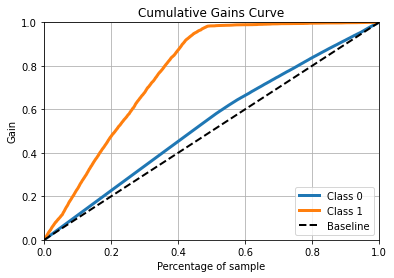

In [163]:
#Accumulative Gain LOGISTIC REGRESSION
skplt.metrics.plot_cumulative_gain( y_test, yhat_lr );

## 8.0. Performance Metrics